# GPU Acceleration

This notebook is intended to demonstrate GPU-acceleration of `superscreen` models.

Below we will look at the time required to solve both single-layer and multi-layer models using three different methods:

1. `Numpy (CPU)`: This is the default behavior when you call `superscreen.solve()` or `superscreen.solve(..., gpu=False)`.
2. `JAX (CPU)`: This method will be used if you call `superscreen.solve(..., gpu=True)` on a machine that has JAX installed but does not have a GPU available. We test this method by forcing JAX to run on the CPU even if a GPU is available using the context manager `jax.default_device(jax.devices("cpu")[0])`.
3. `JAX (GPU)`: This method will be used if you call `superscreen.solve(..., gpu=True)` on a machine that has JAX installed and has a GPU available. This notebook will simply skip this method if no GPU is available.

There are several things to keep in mind in order to get the most out of `SuperScreen` on a GPU:

- Currently, only computation performed inside `superscreen.solve()` can be offloaded to a GPU. Post-processing methods belonging to `superscreen.Solution` cannot (currently) be run on a GPU. Calculations that make heavy use of these post-processing methods (such as fluxoid optimization) can be expected to show only modest speed-ups from GPU acceleration.
- There is some overhead associated with moving data onto the GPU for processing, so calls to `superscreen.solve()` that take only 10s of ms on the CPU (e.g. single-layer models with only 1,000 or so mesh vertices) may actually be slightly slower on the GPU.
- On the other hand, most data only needs to be transferred to the GPU once per call to `superscreen.solve()`, so large gains can be seen when iteratively solving models involving multi-layer devices.

In short, **you can expect the biggest speed-ups for models with many mesh vertices and/or more than one layer**.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import logging
from collections import defaultdict

import jax
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 12

import superscreen as sc
from superscreen.geometry import circle

## Setup

In [2]:
sc.version_table()

Software,Version
SuperScreen,0.6.1
Numpy,1.23.1
SciPy,1.8.1
matplotlib,3.5.2
ray,1.13.0
jax,0.3.15
IPython,8.4.0
Python,"3.9.12 (main, Jun 1 2022, 11:38:51) [GCC 7.5.0]"
OS,posix [linux]
Number of CPUs,"Physical: 2, Logical: 2"


In [3]:
def run_benchmark(device, min_points_values, solve_kwargs):
    # Suppress warnings about not having a GPU.
    logging.getLogger("superscreen.solve").setLevel(logging.CRITICAL)
    mesh_sizes = []
    results = defaultdict(list)
    for min_points in min_points_values:
        device.make_mesh(min_points=min_points, optimesh_steps=10)
        mesh_sizes.append(device.points.shape[0])
        print(f"Mesh size: {device.points.shape[0]}")

        key = "Numpy (CPU)"
        print(f"    {key}: ", end="")
        timing = %timeit -o sc.solve(device, **solve_kwargs)
        results[key].append(timing)

        key = "JAX (CPU)"
        print(f"    {key}: ", end="")
        with jax.default_device(jax.devices("cpu")[0]):
            timing = %timeit -o sc.solve(device, gpu=True, **solve_kwargs)
        results[key].append(timing)

        key = "JAX (GPU)"
        print(f"    {key}: ", end="")
        if "cpu" in jax.devices()[0].device_kind:
            print("Skipping because there is no GPU available.")
        else:
            timing = %timeit -o sc.solve(device, gpu=True, **solve_kwargs)
            results[key].append(timing)
    logging.getLogger("superscreen.solve").setLevel(logging.WARNING)
    return np.array(mesh_sizes), dict(results)

In [4]:
def plot_benchmark(mesh_sizes, results):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, constrained_layout=True)
    ys_ref = np.array([t.average for t in results["Numpy (CPU)"]])
    for label, timing in results.items():
        xs = mesh_sizes
        ys = np.array([t.average for t in timing])
        yerr = np.array([t.stdev for t in timing])
        for ax in axes[:2]:
            ax.errorbar(xs, ys, yerr=yerr, marker="o", ls="--", label=label)
        axes[2].plot(xs, ys_ref / ys, marker="o", ls="--")
    for ax in axes:
        ax.set_xlabel("Mesh size")
        ax.set_ylabel("Solve time [s]")
        ax.grid(True)
    axes[2].set_ylabel("Speed-up vs. Numpy (CPU)")
    axes[0].legend(loc=0)
    axes[1].set_yscale("log")
    return fig, axes

## Single layer device

Here we model a single-layer superconducting ring with some circulating current.

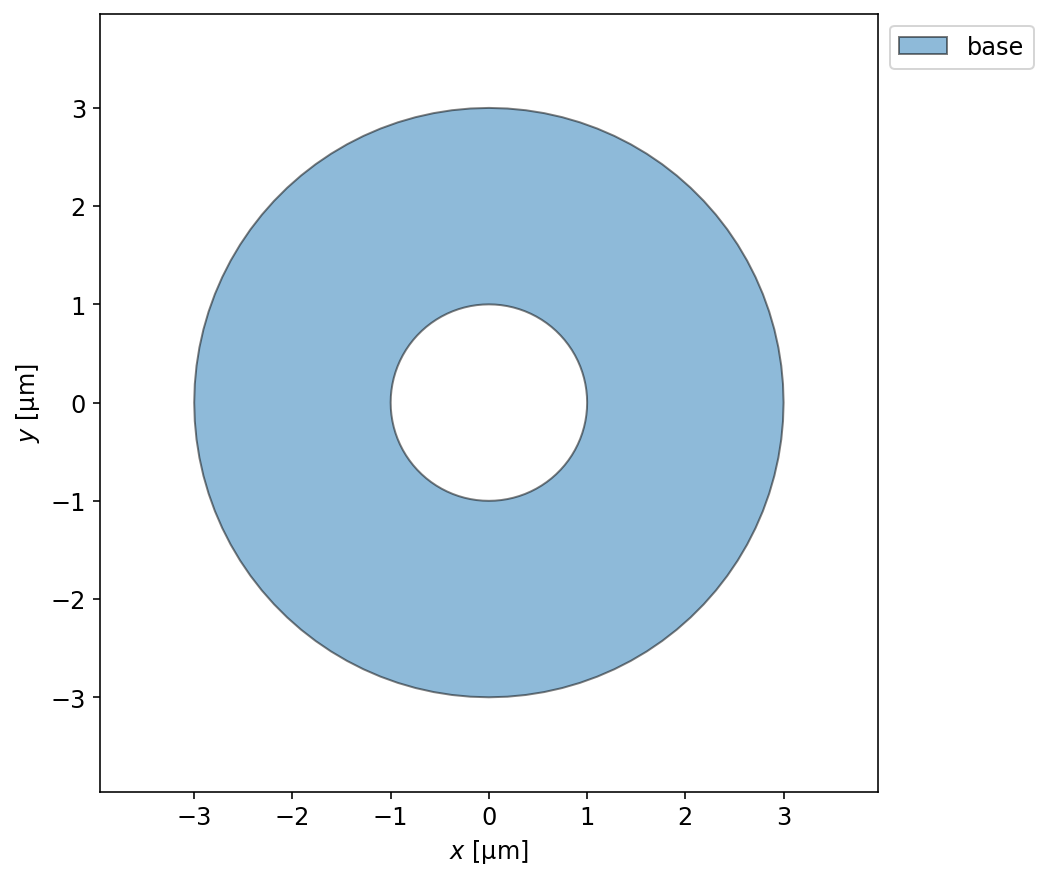

In [5]:
length_units = "um"
ro = 3  # outer radius
ri = 1  # inner radius
slit_width = 0.25
layer = sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)

ring = circle(ro)
hole = circle(ri)
bounding_box = sc.Polygon("bounding_box", layer="base", points=circle(1.2 * ro))

device = sc.Device(
    "ring",
    layers=[sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)],
    films=[sc.Polygon("ring", layer="base", points=ring)],
    holes=[sc.Polygon("hole", layer="base", points=hole)],
    abstract_regions=[bounding_box],
    length_units=length_units,
)
device.solve_dtype = "float32"

fig, ax = device.draw(exclude="bounding_box", legend=True)

We get the same answer for the mutual inductance using either Numpy on the CPU or JAX.

In [6]:
device.make_mesh(min_points=5000, optimesh_steps=10)

In [7]:
M_numpy = device.mutual_inductance_matrix(units="pH", gpu=False)
display(M_numpy)

Magnitude,[[5.814198608377977]]
Units,picohenry


In [8]:
M_jax = device.mutual_inductance_matrix(units="pH", gpu=True)
display(M_jax)

Magnitude,[[5.814189082004743]]
Units,picohenry


Measure the wall time of `superscreen.solve()` vs. the number of points in the mesh.

In [9]:
# Model the device with 1 mA circulating current
circulating_currents = {"hole": "1 mA"}
solve_kwargs = dict(
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
    log_level=None,
)

# Look at solve time vs. mesh size
min_points = 1000 * np.arange(1, 11, dtype=int)

In [10]:
mesh_sizes, results = run_benchmark(device, min_points, solve_kwargs)

Mesh size: 1008
    Numpy (CPU): 14.7 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    JAX (CPU): 52.9 ms ± 4.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 39.4 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 2056
    Numpy (CPU): 129 ms ± 403 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    JAX (CPU): 151 ms ± 3.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 109 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 3091
    Numpy (CPU): 270 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 414 ms ± 9.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 194 ms ± 4.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 4150
    Numpy (CPU): 491 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 728 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX 

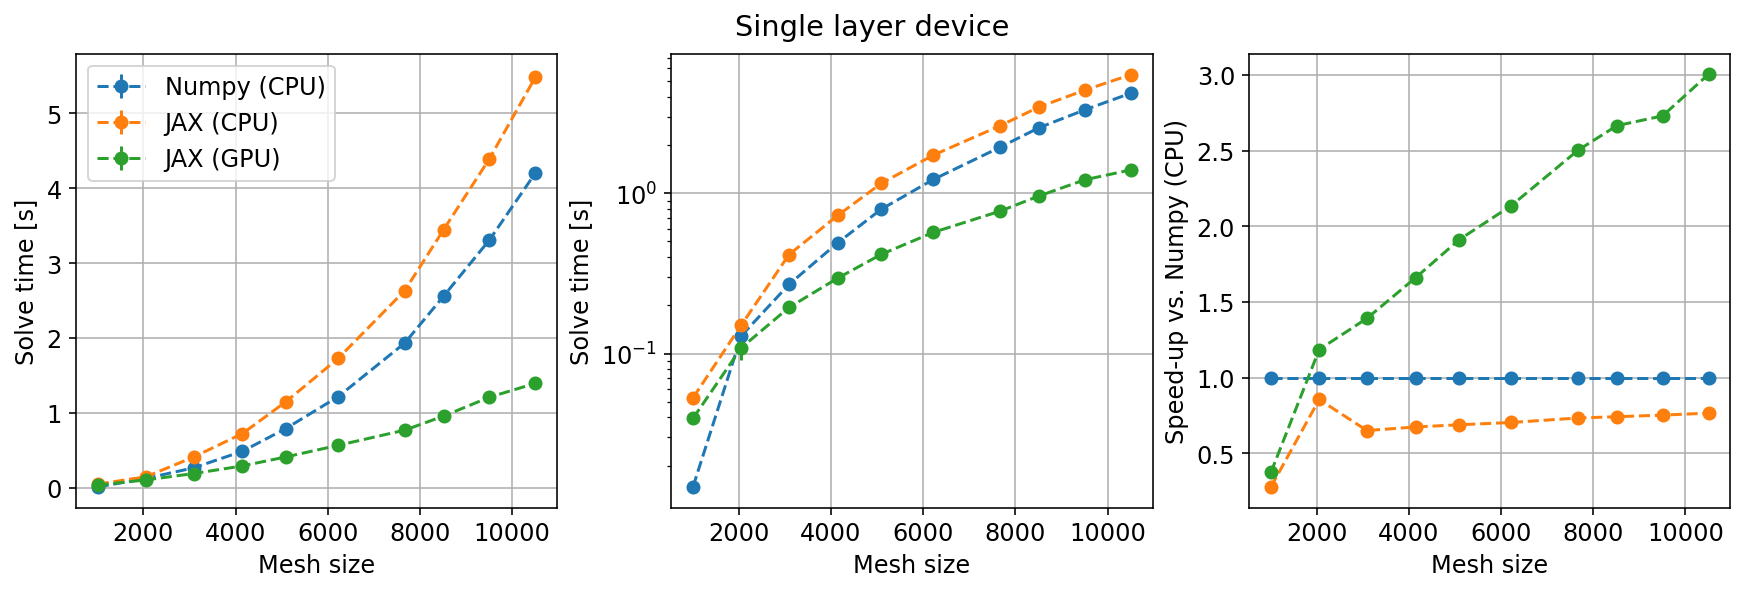

In [11]:
fig, axes = plot_benchmark(mesh_sizes, results)
_ = fig.suptitle("Single layer device")

## Multi-layer device

Here we model a scanning Superconducting QUantum Interference Device (SQUID) susceptometer, which consists of three superconducting layers. In particular, we are interested in the mutual inductance between the **field coil** (green loop below) and **pickup loop** (orange loop below), which lie in different superconducting layers (called BE and W1, respectively).

This is a convenient benchmark because the mutual inductance for these devices has been thoroughly characterized experimentally and was found be in the range $166 \pm 4\,\Phi_0/\mathrm{A}$ (see Table 1 of [arXiv:1605.09483](https://arxiv.org/pdf/1605.09483.pdf) or [DOI:10.1063/1.4961982](https://doi.org/10.1063/1.4961982)).

In [12]:
import squids

In [13]:
device = squids.ibm.medium.make_squid(align_layers="bottom")
device.solve_dtype = "float32"

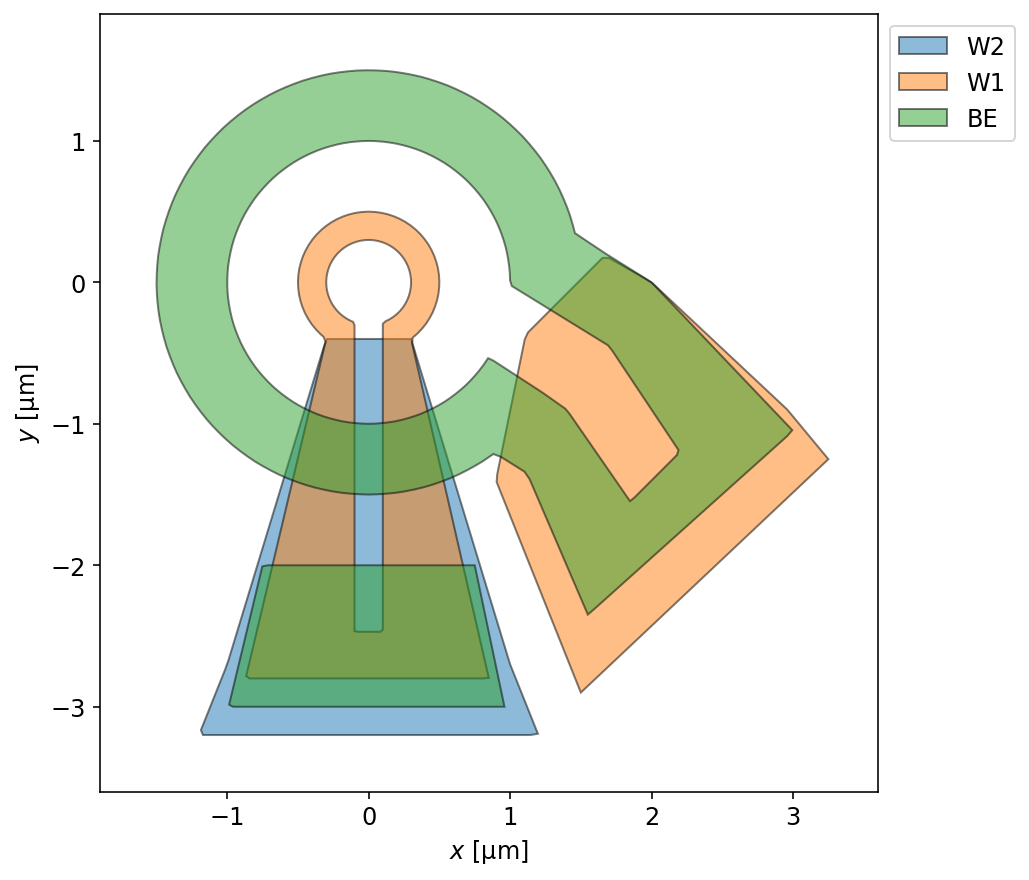

In [14]:
_ = device.draw(exclude="bounding_box", legend=True)

In [15]:
# Model the device with 1 mA circulating current
I_circ = device.ureg("1 mA")
circulating_currents = {"fc_center": str(I_circ)}
solve_kwargs = dict(
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
    log_level=None,
    iterations=5,
)

We get the same answer for the mutual inductance using either Numpy on the CPU or JAX.

In [16]:
device.make_mesh(min_points=6000, optimesh_steps=20)

In [17]:
solution_numpy = sc.solve(device, **solve_kwargs)[-1]
mutual_numpy = (sum(solution_numpy.hole_fluxoid("pl_center")) / I_circ).to("Phi_0 / A")
print(f"mutual_numpy = {mutual_numpy:.5f~P}")

mutual_numpy = 164.89460 Φ_0/A


In [18]:
solution_jax = sc.solve(device, gpu=True, **solve_kwargs)[-1]
mutual_jax = (sum(solution_jax.hole_fluxoid("pl_center")) / I_circ).to("Phi_0 / A")
print(f"mutual_jax = {mutual_jax:.5f~P}")

mutual_jax = 164.89461 Φ_0/A


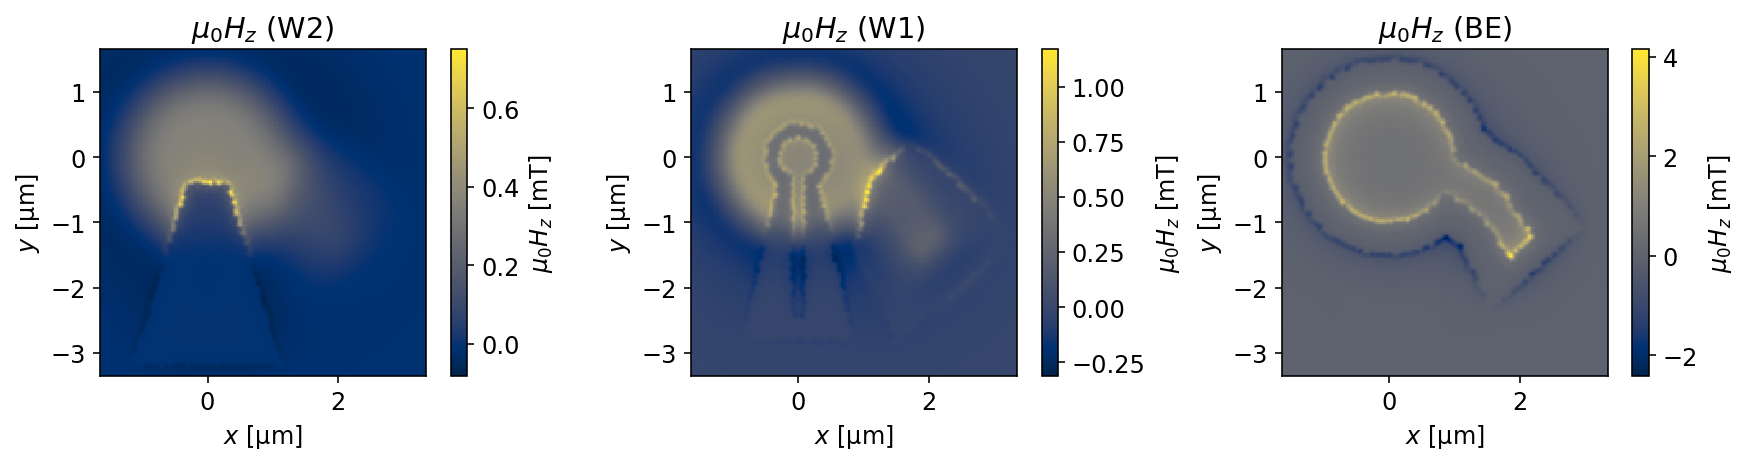

In [19]:
_ = solution_jax.plot_fields(figsize=(15, 3))

Measure the wall time of `superscreen.solve()` vs. the number of points in the mesh.

In [20]:
min_points = 1000 * np.arange(2, 11, dtype=int)

mesh_sizes, results = run_benchmark(device, min_points, solve_kwargs)

Mesh size: 2298
    Numpy (CPU): 1.72 s ± 6.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 1.75 s ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 903 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 3012
    Numpy (CPU): 2.95 s ± 8.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 3.11 s ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 1.04 s ± 5.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 4240
    Numpy (CPU): 5.63 s ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 5.39 s ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 1.38 s ± 5.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 5318
    Numpy (CPU): 8.66 s ± 9.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 7.99 s ± 36.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 1.74

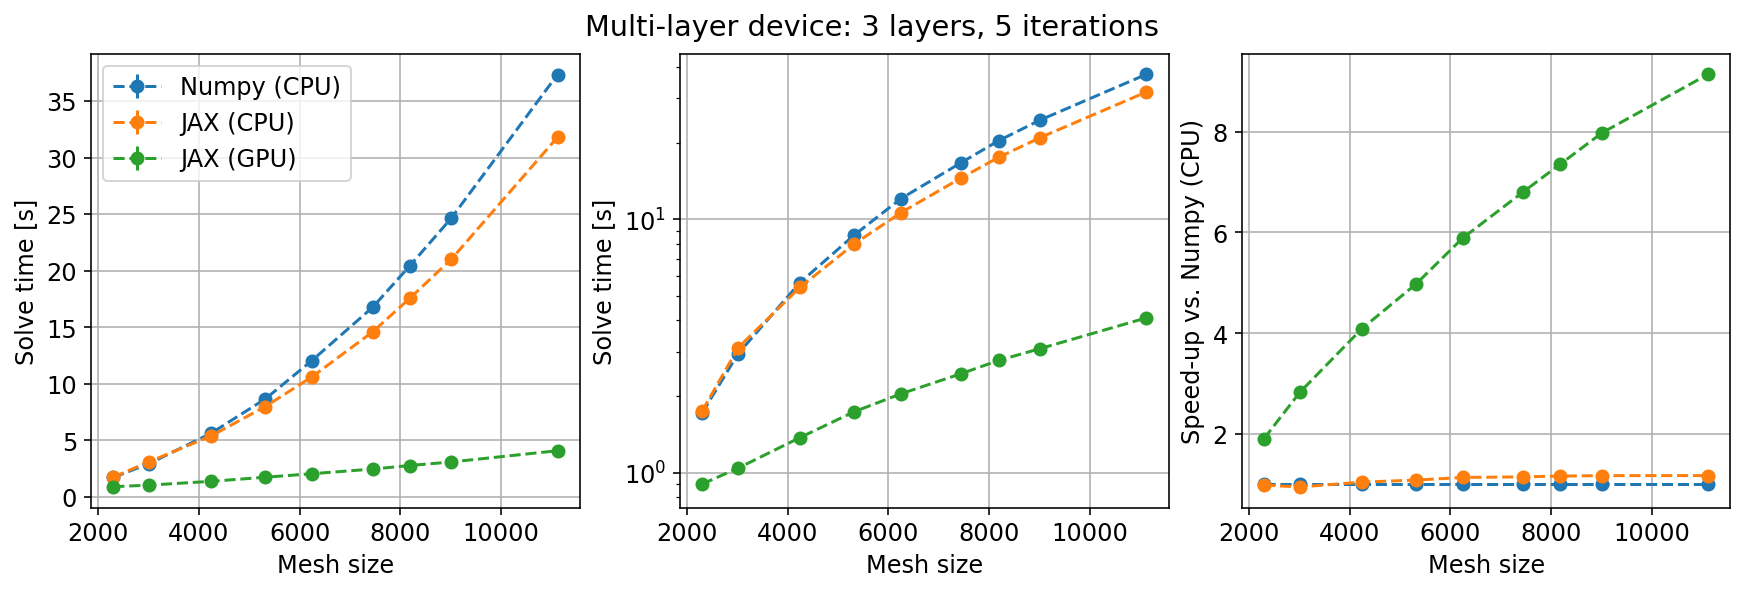

In [21]:
fig, axes = plot_benchmark(mesh_sizes, results)
_ = fig.suptitle(
    f"Multi-layer device: {len(device.layers)} layers, "
    f"{solve_kwargs['iterations']} iterations"
)

Here we measure the solve time vs. the number of iterations for a multi-layer device with a fixed number of mesh vertices.

In [22]:
num_iterations = np.arange(11, dtype=int)
min_points = 6000

results = {}
for iterations in num_iterations:
    print(f"Number of iterations: {iterations}")
    solve_kwargs["iterations"] = iterations
    mesh_size, timing = run_benchmark(device, [min_points], solve_kwargs)
    results[iterations] = timing
    print()

Number of iterations: 0
Mesh size: 6244
    Numpy (CPU): 997 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 1.6 s ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 729 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Number of iterations: 1
Mesh size: 6244
    Numpy (CPU): 9.8 s ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 7.31 s ± 36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 1.17 s ± 8.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Number of iterations: 2
Mesh size: 6244
    Numpy (CPU): 10.4 s ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 8.18 s ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 1.4 s ± 8.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Number of iterations: 3
Mesh size: 6244
    Numpy (CPU): 11 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JA

In [23]:
def plot_iteration_sweep(num_iterations, results):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, constrained_layout=True)
    xs = num_iterations
    ys_ref = np.array([result["Numpy (CPU)"][0].average for result in results.values()])
    labels = list(results[num_iterations[0]])
    for label in labels:
        ys = np.array([result[label][0].average for result in results.values()])
        yerr = np.array([result[label][0].stdev for result in results.values()])
        for ax in axes[:2]:
            ax.errorbar(xs, ys, yerr=yerr, marker="o", ls="--", label=label)
        axes[2].plot(xs, ys_ref / ys, marker="o", ls="--")
    for ax in axes:
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Solve time [s]")
        ax.grid(True)
    axes[2].set_ylabel("Speed-up vs. Numpy (CPU)")
    axes[0].legend(loc=0)
    axes[1].set_yscale("log")
    return fig, axes

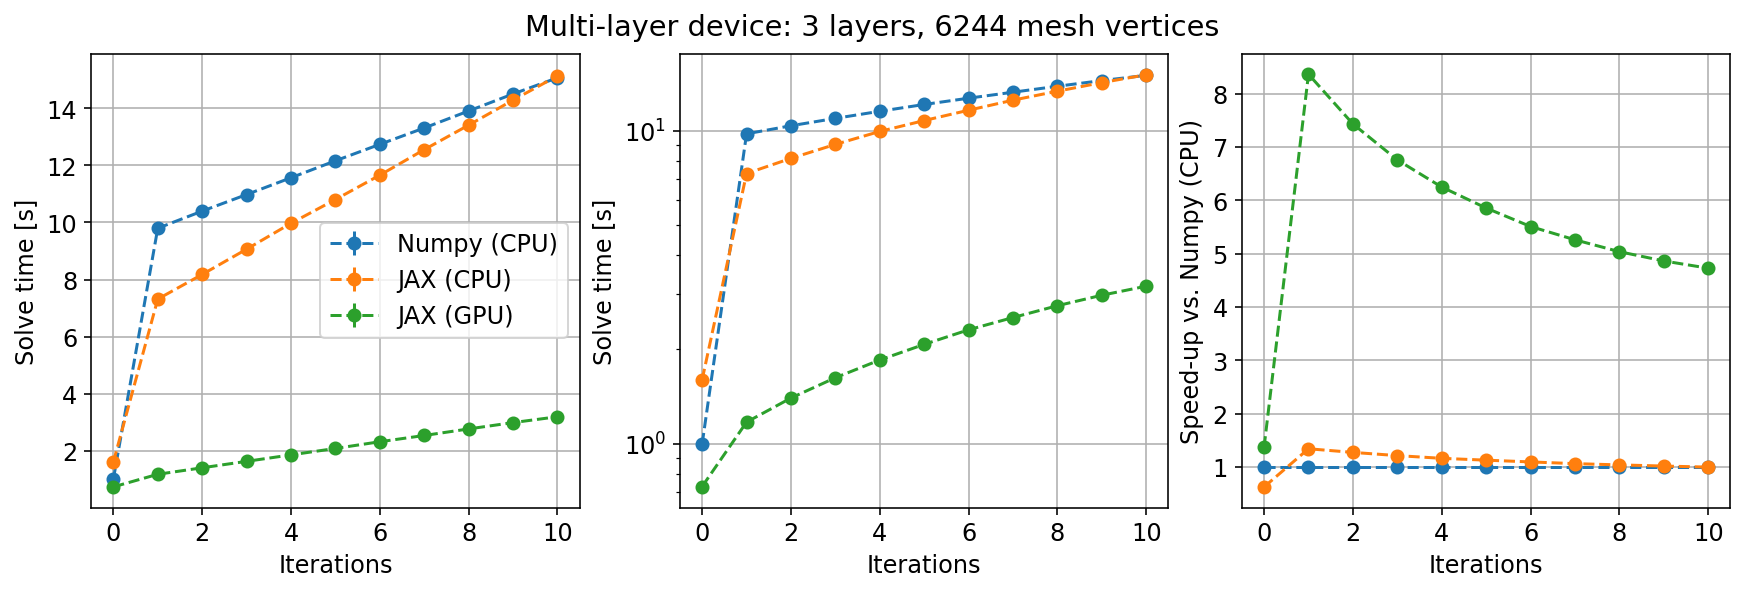

In [24]:
fig, axes = plot_iteration_sweep(num_iterations, results)
_ = fig.suptitle(
    f"Multi-layer device: {len(device.layers)} layers, "
    f"{device.points.shape[0]} mesh vertices"
)